In [16]:
import os
import rasterio
from rasterio.mask import mask
from rasterio import features
from rasterio.transform import rowcol, xy
from rasterio.plot import show
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import shapely
from shapely.geometry import shape, Point
import heapq
import time

In [2]:
%matplotlib inline

In [3]:
def open_raster(file_path):
    """
    Open and read a raster file using the rasterio library.

    Parameters:
    - file_path (str): Path to the raster file.

    Returns:
    - Tuple[numpy.ndarray, Affine, CRS]: A tuple containing:
      - numpy.ndarray: Raster data.
      - Affine: Transformation information.
      - CRS: Coordinate Reference System information.

    The function uses the rasterio library to open the raster file specified by the `file_path`.
    It reads the raster data, transformation information, and CRS (Coordinate Reference System),
    and returns them as a tuple.
    """
    with rasterio.open(file_path) as src:
        raster = src.read(1)
        transform = src.transform
        crs = src.crs
    return raster, transform, crs

In [4]:
def show_raster(raster):
    fig, ax = plt.subplots()
    show(raster, ax=ax)

In [5]:
def smooth_raster(raster, window_size=3, num_iterations=1):
    """
    Apply a smoothing filter to a 2D raster array.

    Parameters:
    - raster (numpy.ndarray): Input 2D array representing the raster data.
    - window_size (int): Size of the square smoothing window. Default is 7x7.
    - num_iterations (int): Number of iterations to apply the smoothing. Default is 1.

    Returns:
    - numpy.ndarray: Smoothened raster array.

    The function applies a convolution operation with a square kernel to smoothen the input raster data.
    The `window_size` determines the size of the square kernel, and `num_iterations` specifies how many
    times the smoothing operation is repeated.
    """
    total_process = raster.shape[0] * num_iterations
    completed = 0
    pad_width = window_size//2
    kernel = np.ones((window_size, window_size))/(window_size)**2
    padded_raster = np.pad(raster, pad_width=pad_width, mode='constant', constant_values=raster.min())
    smoothen_raster = padded_raster
    if num_iterations:
        smoothen_raster = np.zeros_like(padded_raster)
        for i in range(num_iterations):
            for r in range(pad_width, padded_raster.shape[0]-pad_width):
                print(f'\rSmoothing progress: {((completed/total_process)*100):.2f}%', end='', flush=True)
                for c in range(pad_width, padded_raster.shape[1]-pad_width):
                    window = padded_raster[r-pad_width:r+1+pad_width, c-pad_width:c+1+pad_width]
                    smoothen_raster[r, c] = (kernel * window).sum()
                completed += 1
        print('\nSmoothing completed with iterations', num_iterations)
    return smoothen_raster[pad_width:-pad_width, pad_width:-pad_width]

In [6]:
def calculate_peaks(smoothen_raster, window_size=3):
    """
    Calculate peak locations in a smoothened raster using a sliding window approach.

    Parameters:
    - smoothen_raster (numpy.ndarray): Smoothened 2D raster array.
    - window_size (int): Size of the square sliding window. Default is 3x3.

    Returns:
    - Tuple[List[int], List[int]]: A tuple containing two lists:
      - List[int]: Rows of the peak locations.
      - List[int]: Columns of the peak locations.

    The function iterates through the smoothened raster using a sliding window of the specified
    `window_size` and identifies peak locations. Peaks are determined by comparing the center cell
    of the window with the maximum value in the surrounding cells.
    """
    completed = 0
    total_loops = smoothen_raster.shape[0]
    peak_ids = []
    peak_rows = []
    peak_cols = []
    peak_elvs = []
    peak_stongness = []
    pad_width = window_size//2
    center_cell_mask = np.ones((window_size, window_size), dtype=bool)
    center_cell_mask[pad_width, pad_width] = False
    padded_raster = np.pad(smoothen_raster, pad_width=pad_width, mode='constant', constant_values=smoothen_raster.min())
    for r in range(pad_width, padded_raster.shape[0] - pad_width):        
        for c in range(pad_width, padded_raster.shape[1] - pad_width):
            window = padded_raster[r-pad_width:r+1+pad_width, c-pad_width:c+1+pad_width]
            second_highest = max(window[center_cell_mask].ravel())
            center_elv = window[pad_width, pad_width]
            if center_elv > second_highest:
                peak_row = r - pad_width
                peak_col = c - pad_width
                peak_id = str(peak_row)+'_'+str(peak_col)
                peak_elv = center_elv
                peak_ids.append(peak_id)
                peak_rows.append(peak_row)
                peak_cols.append(peak_col)
                peak_elvs.append(peak_elv)
                peak_stongness.append(peak_elv - second_highest)
        completed += 1
        progress = (completed/total_loops) * 100
        print(f"\rCalculating peaks... : {progress:.2f}%", end='', flush=True)
    return peak_ids, peak_rows, peak_cols, peak_elvs, peak_stongness

In [18]:
def make_peak_shapes(peaks, peak_prominences, transform, crs, output_path='peaks.shp', gdf_return=False):
    """
    Create a shapefile representing peak locations from given rows and columns.

    Parameters:
    - peak (Dict): Dictionary containing peak_ids, peak_rows, peak_cols, peak_elvs and peak_strongness lists.
    - transform (Affine): Affine transformation information.
    - crs (CRS): Coordinate Reference System information.
    - output_path (str): Path to save the shapefile. Default is 'peaks.shp'.

    Returns:
    None

    The function takes lists of row and column indices representing peak locations,
    along with the transformation information (`transform`) and CRS information (`crs`).
    It creates a GeoDataFrame with Point geometries based on the peak locations and
    saves it as a shapefile at the specified `output_path`.
    """
    peak_ids, peak_rows, peak_cols, peak_elvs, peak_stongness = peaks
    properties = {"peak_id": peak_ids, "elevation": peak_elvs, "prominence": peak_prominences, "peak_strength": peak_stongness}
    geometry = [Point(xy(transform, y, x)) for x, y in zip(peak_cols, peak_rows)]
    gdf = gpd.GeoDataFrame(properties, geometry=geometry, crs=crs)
    gdf.to_file(output_path, driver='ESRI Shapefile', crs=crs)
    print(output_path, 'saved successfully.')
    if gdf_return:
        return gdf

In [8]:
def grow_and_save_peak_regions(dem, peaks, transform, crs, not_nested=False, relative_drop=None, output_shapefile_path='peak_regions.shp'):
    peak_ids, peak_rows, peak_cols, peak_elvs, peak_strongness = peaks
    processed_peaks = 0
    total_peaks = len(peak_rows)
    total_rows, total_cols = dem.shape
    all_peaks = list(zip(peak_rows, peak_cols))
    # peak_regions = []
    # region_ids = []
    # region_mins = []
    peak_prominences = []
    r_neighbors = [-1, -1, -1, 0, 0, 1, 1, 1]
    c_neighbors = [-1, 0, 1, -1, 1, -1, 0, 1]
    for i, (peak_id, peak_row, peak_col) in enumerate(zip(peak_ids, peak_rows, peak_cols)):
        # if peak_elv == max(peak_elvs):
        #     processed_peaks += 1
        #     continue
        other_peaks = all_peaks[:i] + all_peaks[i+1:]
        peak_val = dem[peak_row, peak_col]
        min_elv = peak_val
        min_index = 0
        min_region = np.zeros_like(dem, dtype='uint8')
        peak_region = np.zeros_like(dem, dtype='uint8')
        done = np.zeros_like(dem, dtype=bool)
        pq = []
        heapq.heapify(pq)
        heapq.heappush(pq, (-peak_val, (peak_row, peak_col)))
        while pq:
            neg_elv, (r, c) = heapq.heappop(pq)
            elv = -neg_elv
            if done[r, c]:
                continue
            if elv <= peak_val:
                if not_nested:
                    if (r,c) in other_peaks:
                        break
                if relative_drop:
                    if peak_val - elv > relative_drop:
                        break
                peak_region[r, c] = 1
                if elv < min_elv:
                    min_elv = elv
                    min_region = peak_region.copy()
                    saddle_r = r
                    saddle_c = c
                
                for i in range(8):
                    rn = r + r_neighbors[i]
                    cn = c + c_neighbors[i]
                    if (rn < 0 or rn >= total_rows or
                        cn < 0 or cn >= total_cols):
                        continue
                    if done[rn, cn]:
                        continue
                    heapq.heappush(pq, (-dem[rn, cn], (rn, cn)))
                done[r, c] = True
            else:
                break

        mask = (min_region==1).astype('uint8')
        shapes = features.shapes(mask, transform=transform, connectivity=8)
        s_c, s_r = (transform * (saddle_c, saddle_r))
        geom = [shape(s) for s, v in shapes if v==1]
        properties = {"peak_id": [peak_id],
                     "peak_elv": [peak_val],
                     "min_elv": [min_elv],
                     "prominence": [elv - min_elv],
                     "saddle_r": [s_r],
                     "saddle_c": [s_c]}
        gdf = gpd.GeoDataFrame(properties, geometry=geom, crs=crs)
        if os.path.exists(output_shapefile_path):
            gdf.to_file(output_shapefile_path, driver='ESRI Shapefile', crs=crs, mode='a')
        else:
            gdf.to_file(output_shapefile_path, driver='ESRI Shapefile', crs=crs)
        peak_prominences.append(elv - min_elv)
        processed_peaks += 1
        progress = (processed_peaks/total_peaks)*100
        print(f'\rProgress: {progress:.2f}%, remaining:{total_peaks-processed_peaks}, processed:{processed_peaks}', end='', flush=True)
    print(f'\n{output_shapefile_path} saved successfully...')
    return peak_prominences

In [9]:
# def grow_and_save_peak_regions(dem, peaks, transform, crs, not_nested=False, relative_drop=None, output_shapefile_path='peak_regions.shp'):
#     peak_ids, peak_rows, peak_cols, peak_elvs, peak_strongness = peaks
#     processed_peaks = 0
#     total_peaks = len(peak_rows)
#     total_rows, total_cols = dem.shape
#     all_peaks = list(zip(peak_rows, peak_cols))
#     # peak_regions = []
#     # region_ids = []
#     # region_mins = []
#     peak_prominences = []
#     r_neighbors = [-1, -1, -1, 0, 0, 1, 1, 1]
#     c_neighbors = [-1, 0, 1, -1, 1, -1, 0, 1]
#     for i, (peak_id, peak_row, peak_col) in enumerate(zip(peak_ids, peak_rows, peak_cols)):
#         # if peak_elv == max(peak_elvs):
#         #     processed_peaks += 1
#         #     continue
#         other_peaks = all_peaks[:i] + all_peaks[i+1:]
#         peak_val = dem[peak_row, peak_col]
#         min_elv = peak_val
#         min_index = 0
#         min_region = np.zeros_like(dem, dtype='uint8')
#         peak_region = np.zeros_like(dem, dtype='uint8')
#         done = np.zeros_like(dem, dtype=bool)
#         pq = []
#         heapq.heapify(pq)
#         heapq.heappush(pq, (-peak_val, (peak_row, peak_col)))
#         while pq:
#             neg_elv, (r, c) = heapq.heappop(pq)
#             elv = -neg_elv
#             if done[r, c]:
#                 continue
#             if elv <= peak_val:
#                 if not_nested:
#                     if (r,c) in other_peaks:
#                         break
#                 if relative_drop:
#                     if peak_val - elv > relative_drop:
#                         break
#                 peak_region[r, c] = 1
#                 if elv < min_elv:
#                     min_elv = elv
#                     min_region = peak_region.copy()
                
#                 for i in range(8):
#                     rn = r + r_neighbors[i]
#                     cn = c + c_neighbors[i]
#                     if (rn < 0 or rn >= total_rows or
#                         cn < 0 or cn >= total_cols):
#                         continue
#                     if done[rn, cn]:
#                         continue
#                     heapq.heappush(pq, (-dem[rn, cn], (rn, cn)))
#                 done[r, c] = True
#             else:
#                 break

#         mask = (min_region==1).astype('uint8')
#         shapes = features.shapes(mask, transform=transform, connectivity=8)
#         geom = [shape(s) for s, v in shapes if v==1]
#         properties = {"peak_id": [peak_id],
#                      "peak_elv": [peak_val],
#                      "min_elv": [min_elv],
#                      "prominence": [elv - min_elv]}
#         gdf = gpd.GeoDataFrame(properties, geometry=geom, crs=crs)
#         if os.path.exists(output_shapefile_path):
#             gdf.to_file(output_shapefile_path, driver='ESRI Shapefile', crs=crs, mode='a')
#         else:
#             gdf.to_file(output_shapefile_path, driver='ESRI Shapefile', crs=crs)
#         peak_prominences.append(elv - min_elv)
#         processed_peaks += 1
#         progress = (processed_peaks/total_peaks)*100
#         print(f'\rProgress: {progress:.2f}%, remaining:{total_peaks-processed_peaks}, processed:{processed_peaks}', end='', flush=True)
#     print(f'\n{output_shapefile_path} saved successfully...')
#     return peak_prominences

In [10]:
# def grow_peak_regions(dem, peaks, not_nested=False, relative_drop=None):
#     peak_ids, peak_rows, peak_cols, peak_elvs, peak_strongness = peaks
#     processed_peaks = 0
#     total_peaks = len(peak_rows)
#     total_rows, total_cols = dem.shape
#     all_peaks = list(zip(peak_rows, peak_cols))
#     peak_regions = []
#     region_ids = []
#     region_mins = []
#     peak_prominences = []
#     r_neighbors = [-1, -1, -1, 0, 0, 1, 1, 1]
#     c_neighbors = [-1, 0, 1, -1, 1, -1, 0, 1]
#     for i, (peak_id, peak_row, peak_col) in enumerate(zip(peak_ids, peak_rows, peak_cols)):
#         other_peaks = all_peaks[:i] + all_peaks[i+1:]
#         peak_val = dem[peak_row, peak_col]
#         min_elv = peak_val
#         min_index = 0
#         min_region = np.zeros_like(dem, dtype='uint8')
#         peak_region = np.zeros_like(dem, dtype='uint8')
#         done = np.zeros_like(dem, dtype=bool)
#         pq = []
#         heapq.heapify(pq)
#         heapq.heappush(pq, (-peak_val, (peak_row, peak_col)))
#         while pq:
#             neg_elv, (r, c) = heapq.heappop(pq)
#             elv = -neg_elv
#             if done[r, c]:
#                 continue
#             if elv <= peak_val:
#                 if not_nested:
#                     if (r,c) in other_peaks:
#                         break
#                 if relative_drop:
#                     if peak_val - elv > relative_drop:
#                         break
#                 peak_region[r, c] = 1
#                 if elv < min_elv:
#                     min_elv = elv
#                     min_region = peak_region.copy()
                
#                 for i in range(8):
#                     rn = r + r_neighbors[i]
#                     cn = c + c_neighbors[i]
#                     if (rn < 0 or rn >= total_rows or
#                         cn < 0 or cn >= total_cols):
#                         continue
#                     if done[rn, cn]:
#                         continue
#                     heapq.heappush(pq, (-dem[rn, cn], (rn, cn)))
#                 done[r, c] = True
#             else:
#                 break
#         peak_regions.append(min_region)
#         region_ids.append(peak_id)
#         region_mins.append(min_elv)
#         peak_prominences.append(elv - min_elv)
#         processed_peaks += 1
#         progress = (processed_peaks/total_peaks)*100
#         print(f'\rProgress: {progress:.2f}%, remaining:{total_peaks-processed_peaks}, processed:{processed_peaks}', end='', flush=True)
#     return peak_regions, region_ids, peak_elvs, region_mins, peak_prominences, peak_strongness

In [11]:
def generate_region_rasters(peak_regions, ids, folder_name):
    for region, id in zip(peak_regions, ids):
        if not os.path.exists(folder_name):
            os.makedirs(folder_name)
        file_name = f'{folder_name}/{id}.tif'
        with rasterio.open(file_name, 'w',
                           driver='GTiff',
                           height=region.shape[0],
                           width=region.shape[1],
                           count=1,
                           dtype=str(region.dtype),
                           transform=transform,crs=crs) as dst:
            dst.write(region, 1)
        print(file_name, 'saved successfully.')

In [12]:
def save_as_shapefiles(regions, transform, crs, output_shapefile_path='mountains.shp', gdf_return=False):
    """
    Save peak regions as shapefiles.

    Parameters:
    - peak_regions (List[numpy.ndarray]): List of binary arrays representing peak regions.
    - transform (Affine): Affine transformation information.
    - crs (CRS): Coordinate Reference System information.
    - output_shapefile_path (str): Path to save the shapefile. Default is 'mountains.shp'.

    Returns:
    None

    The function takes a list of peak regions and their corresponding transformation and CRS information.
    It converts each peak region to a GeoDataFrame and saves it as a shapefile at the specified
    `output_shapefile_path`.
    """
    peak_regions, region_ids, peak_elvs, region_mins, peak_prominences, peak_strongness = regions
    all_shapes = []
    for region, id, elv, min_elv, prominence, peak_str in zip(peak_regions, region_ids, peak_elvs, region_mins, peak_prominences, peak_strongness):
        mask = (region==1).astype('uint8')
        shapes = features.shapes(mask, transform=transform, connectivity=8)
        for s, v in shapes:
            if v==1:
                all_shapes.append((shape(s), id, elv, min_elv, prominence, peak_str))
        # all_shapes.extend((shape(s), v) for s, v in shapes if v==1)
    properties = {"peak_id": region_ids,
                 "peak_elv": peak_elvs,
                 "min_elv": region_mins,
                 "prominence": peak_prominences,
                 "strngth": peak_strongness}
    gdf = gpd.GeoDataFrame(properties, geometry=[shape(s) for s, id, elv, min_elv, prominence, peak_str in all_shapes], crs=crs)
    # gdf = gpd.GeoDataFrame(geometry=[shape(s) for s, v in all_shapes], crs=crs)
    gdf.to_file(output_shapefile_path, driver='ESRI Shapefile', crs=crs)
    print(output_shapefile_path, 'saved successfully.')
    if gdf_return:
        return gdf

In [13]:
def get_prominent_peaks(peaks, prominences, prominence_thresh=5):
    peak_ids, peak_rows, peak_cols, peak_elvs, peak_stongness = peaks
    prominent_peaks = ([], [], [], [], [])
    peak_prominences = []
    for peak_id, peak_row, peak_col, peak_elv, peak_str, peak_promi in zip(peak_ids, peak_rows, peak_cols, peak_elvs, peak_stongness, prominences):
        if peak_promi >= prominence_thresh:
            prominent_peaks[0].append(peak_id)
            prominent_peaks[1].append(peak_row)
            prominent_peaks[2].append(peak_col)
            prominent_peaks[3].append(peak_elv)
            prominent_peaks[4].append(peak_str)
            peak_prominences.append(peak_promi)
    return prominent_peaks, peak_prominences

In [14]:
file_path = r'C:\Users\somadder\Thesis\SM\SM.tif'

In [15]:
current_dir = os.path.dirname(file_path)
os.chdir(current_dir)

In [14]:
raster, transform, crs = open_raster(file_path=file_path)

In [15]:
peaks = calculate_peaks(raster, window_size=3)

Calculating peaks... : 100.00%

In [16]:
start = time.time()
prominences = grow_and_save_peak_regions(raster, peaks, transform, crs, output_shapefile_path='cp_30m_p3_regions_saddle.shp')
end = time.time()

Progress: 100.00%, remaining:0, processed:87710000
cp_30m_p3_regions_saddle.shp saved successfully...


In [17]:
end - start

51473.43202161789

In [18]:
make_peak_shapes(peaks, prominences, transform, crs, output_path="cp_30m_p3_peaks_saddle.shp")

C:\Users\somadder\AppData\Local\Temp\ipykernel_14328\664363348.py:23: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf.to_file(output_path, driver='ESRI Shapefile', crs=crs)


cp_30m_p3_peaks_saddle.shp saved successfully.


In [29]:
# save_as_shapefiles(regions, transform, crs, "sm_p3_regions.shp", False)

In [16]:
# peaks_sm = gpd.read_file("sm_p3_peaks.shp")

In [26]:
# prominences = peaks_sm['prominence'].tolist()

In [21]:
prominent_peaks, peak_prominences = get_prominent_peaks(peaks, prominences, prominence_thresh=5)

In [22]:
_ = grow_and_save_peak_regions(raster, prominent_peaks, transform, crs, not_nested=True, output_shapefile_path='sm_30m_p3_regions_prominent_5m.shp')

Progress: 100.00%, remaining:0, processed:28758888
sm_30m_p3_regions_prominent_5m.shp saved successfully...


In [23]:
prominent_peaks, peak_prominences = get_prominent_peaks(peaks, prominences, prominence_thresh=10)

In [24]:
_ = grow_and_save_peak_regions(raster, prominent_peaks, transform, crs, not_nested=True, output_shapefile_path='sm_30m_p3_regions_prominent_10m.shp')

Progress: 100.00%, remaining:0, processed:1463111
sm_30m_p3_regions_prominent_10m.shp saved successfully...


In [11]:
file_path = r'C:\Users\somadder\Thesis\Testing\presrange10m.tif'

In [12]:
current_dir = os.path.dirname(file_path)
os.chdir(current_dir)

In [13]:
raster, transform, crs = open_raster(file_path=file_path)

In [14]:
# for i in range(3, 5000, 2):
#     print(f'window size {i}x{i} in progress...\n')
#     if i == 3:
#         peak_ids, peak_rows, peak_cols, peak_elvs, peak_stongness = calculate_peaks(raster, window_size=i)
#         properties = {"peak_id": peak_ids, "elevation": peak_elvs, "peak_strength": peak_stongness}
#         geometry = [Point(transform * (x, y)) for x, y in zip(peak_cols, peak_rows)]
#         peak_gdf = gpd.GeoDataFrame(properties, geometry=geometry, crs=crs)
#     else:
#         peak_ids, peak_rows, peak_cols, peak_elvs, peak_stongness = calculate_peaks(raster, window_size=i)
#     if len(peak_rows) <= 5:
#         break
#     peak_gdf.loc[peak_gdf['peak_id'].isin(peak_ids), 'isolation'] = str((i//2)*10)+'m'

In [15]:
# peak_gdf.to_file("d10_p3_iso.shp", driver='ESRI Shapefile', crs=crs)

In [16]:
peaks = calculate_peaks(raster, window_size=3)

Calculating peaks... : 100.00%

In [17]:
gdf_p = gpd.read_file("d10_p3_iso.shp")

In [22]:
prominence_list = gdf_p['prominence'].tolist()

In [23]:
# regions = grow_peak_regions(raster, peaks)

In [25]:
prominent_peaks, peak_prominences = get_prominent_peaks(peaks, prominence_list, prominence_thresh=5)

In [81]:
prominent_regions = grow_peak_regions(raster, prominent_peaks, prominent_peaks=True)

Progress: 100.00%, remaining:0, processed:3799

In [82]:
peak_regions, region_ids, peak_elvs, region_mins, region_prominences, peak_strongness = prominent_regions

In [84]:
save_as_shapefiles((peak_regions, region_ids, peak_elvs, region_mins, peak_prominences, peak_strongness), transform, crs, "d10_p3_regions_prominent_5m.shp", False)

d10_p3_regions_prominent_5m.shp saved successfully.


In [86]:
prominent_peaks, peak_prominences = get_prominent_peaks(peaks, prominence_list, prominence_thresh=10)

In [87]:
prominent_regions = grow_peak_regions(raster, prominent_peaks, prominent_peaks=True)

Progress: 100.00%, remaining:0, processed:2755

In [88]:
peak_regions, region_ids, peak_elvs, region_mins, region_prominences, peak_strongness = prominent_regions

In [89]:
save_as_shapefiles((peak_regions, region_ids, peak_elvs, region_mins, peak_prominences, peak_strongness), transform, crs, "d10_p3_regions_prominent_10m.shp", False)

d10_p3_regions_prominent_10m.shp saved successfully.


In [90]:
prominent_peaks, peak_prominences = get_prominent_peaks(peaks, prominence_list, prominence_thresh=15)

In [91]:
prominent_regions = grow_peak_regions(raster, prominent_peaks, prominent_peaks=True)

Progress: 100.00%, remaining:0, processed:2133

In [92]:
peak_regions, region_ids, peak_elvs, region_mins, region_prominences, peak_strongness = prominent_regions

In [93]:
save_as_shapefiles((peak_regions, region_ids, peak_elvs, region_mins, peak_prominences, peak_strongness), transform, crs, "d10_p3_regions_prominent_15m.shp", False)

d10_p3_regions_prominent_15m.shp saved successfully.


In [95]:
prominent_relative_regions = grow_peak_regions(raster, prominent_peaks, not_nested=False, relative_drop=50)

Progress: 100.00%, remaining:0, processed:2133

In [96]:
peak_regions, region_ids, peak_elvs, region_mins, region_prominences, peak_strongness = prominent_relative_regions

In [97]:
save_as_shapefiles((peak_regions, region_ids, peak_elvs, region_mins, peak_prominences, peak_strongness), transform, crs, "d10_p3_regions_prominent_15m_relative_50m.shp", False)

d10_p3_regions_prominent_15m_relative_50m.shp saved successfully.


In [25]:
# def grow_prominent_peaks (dem, peaks, prominece_thresh=None):
#     regions = grow_peak_regions(dem, peaks)
#     if prominece_thresh:
#         peak_ids, peak_rows, peak_cols, peak_elvs, peak_stongness = peaks
#         prominent_peaks = ([], [], [], [], [])
#         peak_prominences = []
#         for peak_id, peak_row, peak_col, peak_elv, peak_str, peak_promi in zip(peak_ids, peak_rows, peak_cols, peak_elvs, peak_stongness, regions[4]):
#             if peak_promi >= prominece_thresh:
#                 prominent_peaks[0].append(peak_id)
#                 prominent_peaks[1].append(peak_row)
#                 prominent_peaks[2].append(peak_col)
#                 prominent_peaks[3].append(peak_elv)
#                 prominent_peaks[4].append(peak_str)
#                 peak_prominences.append(peak_promi)
#         prominent_regions = grow_peak_regions(dem, prominent_peaks, prominent_peaks=True)
#         peak_regions, region_ids, peak_elvs, region_mins, region_prominences, peak_strongness = prominent_regions
#         return peak_regions, region_ids, peak_elvs, region_mins, peak_prominences, peak_strongness
#     else:
#         return regions

In [60]:
# make_peak_shapes(peaks, regions[4], transform, crs, output_path="d10_p3.shp")

C:\Users\somadder\AppData\Local\Temp\ipykernel_17152\1093854031.py:23: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf.to_file(output_path, driver='ESRI Shapefile', crs=crs)


d10_p3.shp saved successfully.


In [22]:
# generate_region_rasters(peak_regions, ids, "t")

In [66]:
# gdf = save_as_shapefiles(regions, transform, crs, "d10_p3_regions.shp", True)

d10_p3_regions.shp saved successfully.


In [88]:
pgdf = gpd.read_file("d10_p3_iso_m.shp")

In [90]:
# pgdf["gnis"] = pgdf["S_name"].apply(lambda x: "No" if x=='0' else "GNIS")

In [89]:
pgdf

,peak_id,elevation,peak_stren,isolation,S_name,S_dis,Close_M,Close_M_Di,iso_m,prominence,gnis,geometry
0,0535,394.656921,0.006653,10m,0,0.0000,Boy Mountain,2221.5400,10,0.085449,No,POINT (307050.000 4916000.000)
1,0762,651.686218,0.196411,800m,Boy Mountain,87.3433,Boy Mountain,87.3433,800,46.915100,GNIS,POINT (309320.000 4916000.000)
2,0802,607.435486,0.064453,40m,0,0.0000,Boy Mountain,455.2120,40,1.311890,No,POINT (309720.000 4916000.000)
3,0858,674.909607,0.046692,1120m,0,0.0000,Boy Mountain,1012.0300,1000,122.916000,No,POINT (310280.000 4916000.000)
4,01007,564.471313,0.214966,30m,0,0.0000,Boy Mountain,2500.4400,30,1.083440,No,POINT (311770.000 4916000.000)
...,...,...,...,...,...,...,...,...,...,...,...,...
2756,35991962,745.807922,0.022400,10m,0,0.0000,Little Attitash Mountain,1518.3100,10,0.159302,No,POINT (321320.000 4880010.000)
2757,35991976,763.305420,0.056335,10m,0,0.0000,Little Attitash Mountain,1457.0500,10,0.171509,No,POINT (321460.000 4880010.000)
2758,35991978,763.420593,0.122314,20m,0,0.0000,Little Attitash Mountain,1449.2000,20,0.481934,No,POINT (321480.000 4880010.000)
2759,35991985,765.370789,0.171753,380m,0,0.0000,Little Attitash Mountain,1423.5700,380,21.669200,No,POINT (321550.000 4880010.000)


In [86]:
# for i in range(203, 5000, 2):
#     print(f'\nwindow size {i}x{i} in progress...')
#     peak_ids, peak_rows, peak_cols, peak_elvs, peak_stongness = calculate_peaks(raster, window_size=i)
#     if len(peak_rows) <= 2:
#         break
#     pgdf.loc[pgdf['peak_id'].isin(peak_ids), 'isolation'] = str((i//2)*10)+'m'
#     pgdf.to_file("d10_p3_iso_m.shp", driver='ESRI Shapefile')


window size 203x203 in progress...
Calculating peaks... : 100.00%
window size 205x205 in progress...
Calculating peaks... : 100.00%
window size 207x207 in progress...
Calculating peaks... : 100.00%
window size 209x209 in progress...
Calculating peaks... : 100.00%
window size 211x211 in progress...
Calculating peaks... : 100.00%
window size 213x213 in progress...
Calculating peaks... : 100.00%
window size 215x215 in progress...
Calculating peaks... : 100.00%
window size 217x217 in progress...
Calculating peaks... : 100.00%
window size 219x219 in progress...
Calculating peaks... : 100.00%
window size 221x221 in progress...
Calculating peaks... : 100.00%
window size 223x223 in progress...
Calculating peaks... : 100.00%
window size 225x225 in progress...
Calculating peaks... : 100.00%
window size 227x227 in progress...
Calculating peaks... : 83.14%

KeyboardInterrupt: 

Text(0, 0.5, 'Elevation')

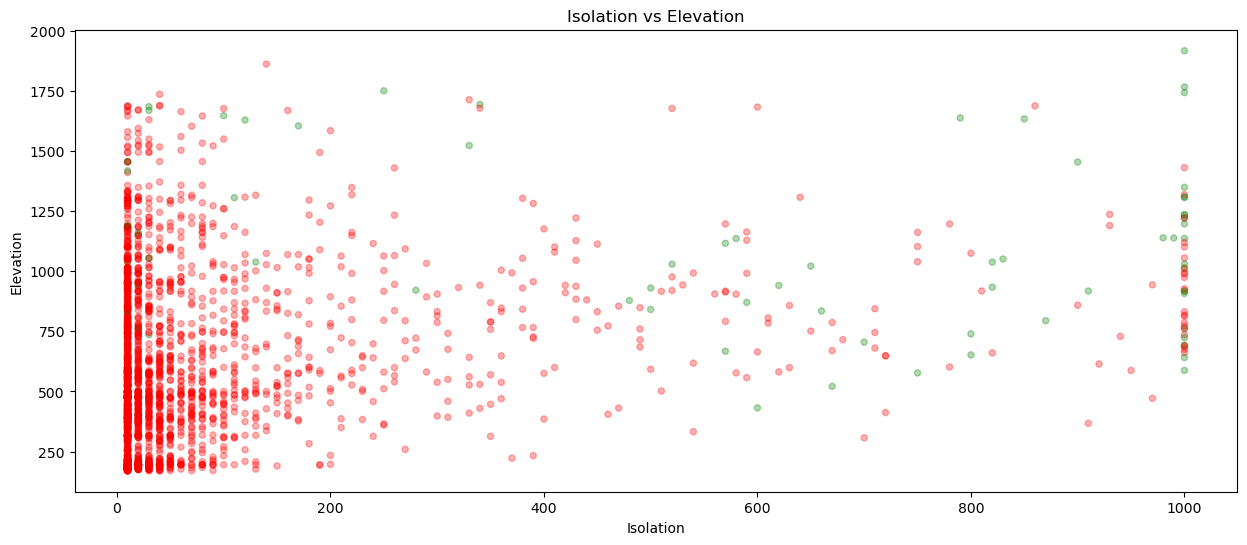

In [40]:
color_map = {"No": "red", "GNIS": "green"}
fig, ax = plt.subplots(figsize=(15, 6))
pgdf.plot(kind="scatter", x="iso_m", y="elevation", c=pgdf['gnis'].map(color_map), alpha=0.3, ax=ax)
ax.set_title("Isolation vs Elevation")
ax.set_xlabel("Isolation")  
ax.set_ylabel("Elevation")

Text(0, 0.5, 'Prominence')

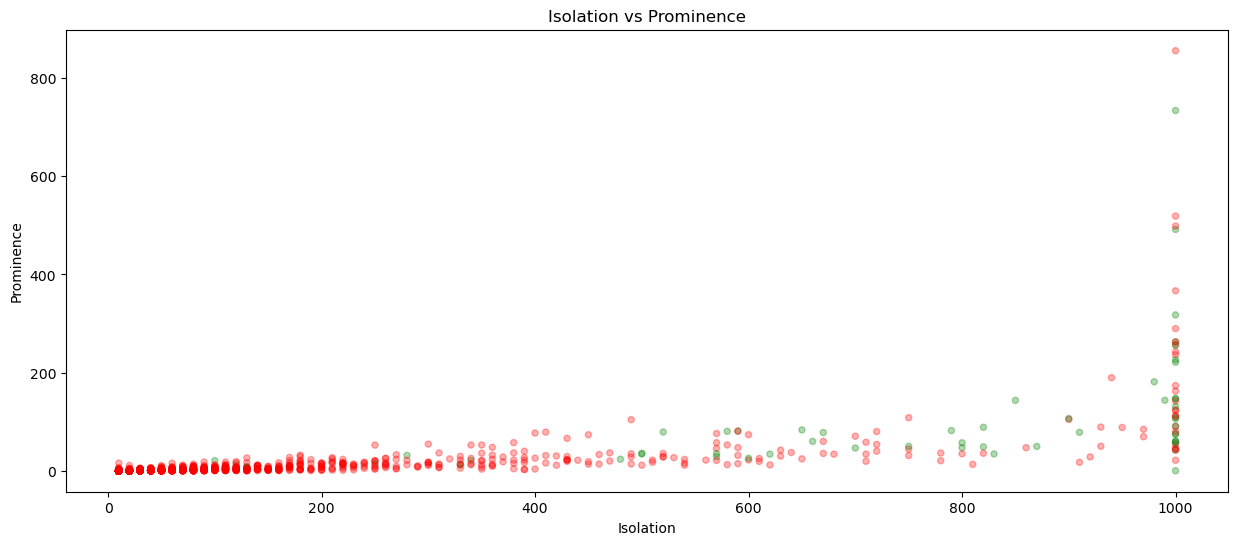

In [30]:
color_map = {"No": "red", "GNIS": "green"}
fig, ax = plt.subplots(figsize=(15, 6))
pgdf.plot(kind="scatter", x="iso_m", y="prominence", c=pgdf['gnis'].map(color_map), alpha=0.3, ax=ax)
ax.set_title("Isolation vs Prominence")
ax.set_xlabel("Isolation")  
ax.set_ylabel("Prominence")

Text(0, 0.5, 'Prominence')

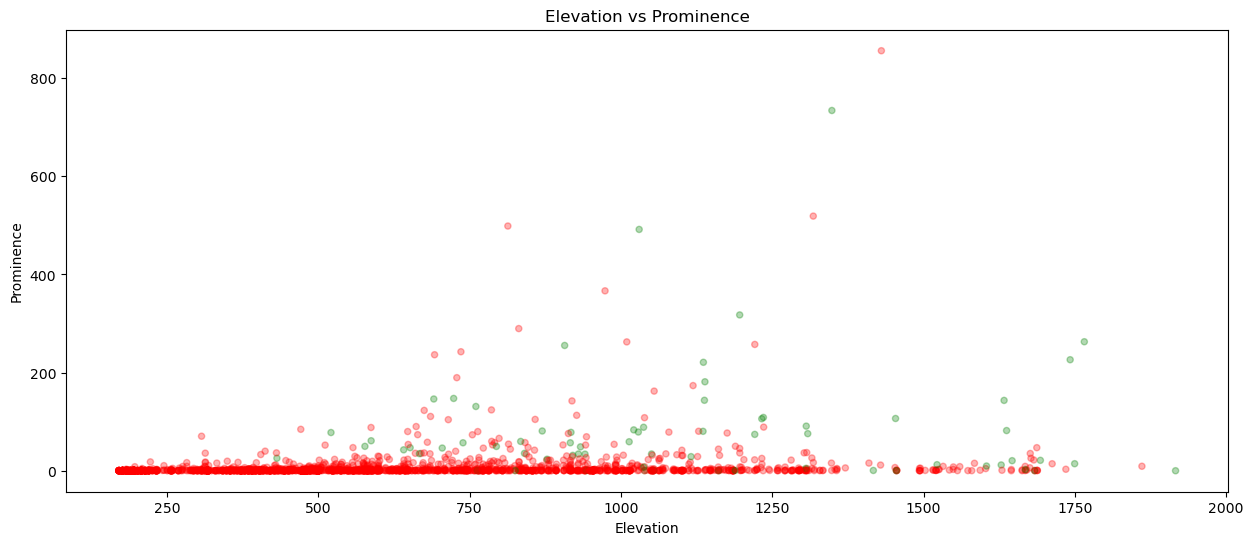

In [42]:
color_map = {"No": "red", "GNIS": "green"}
fig, ax = plt.subplots(figsize=(15, 6))
pgdf.plot(kind="scatter", x="elevation", y="prominence", c=pgdf['gnis'].map(color_map), alpha=0.3, ax=ax)
ax.set_title("Elevation vs Prominence")
ax.set_xlabel("Elevation")  
ax.set_ylabel("Prominence")

Text(0, 0.5, 'Prominence')

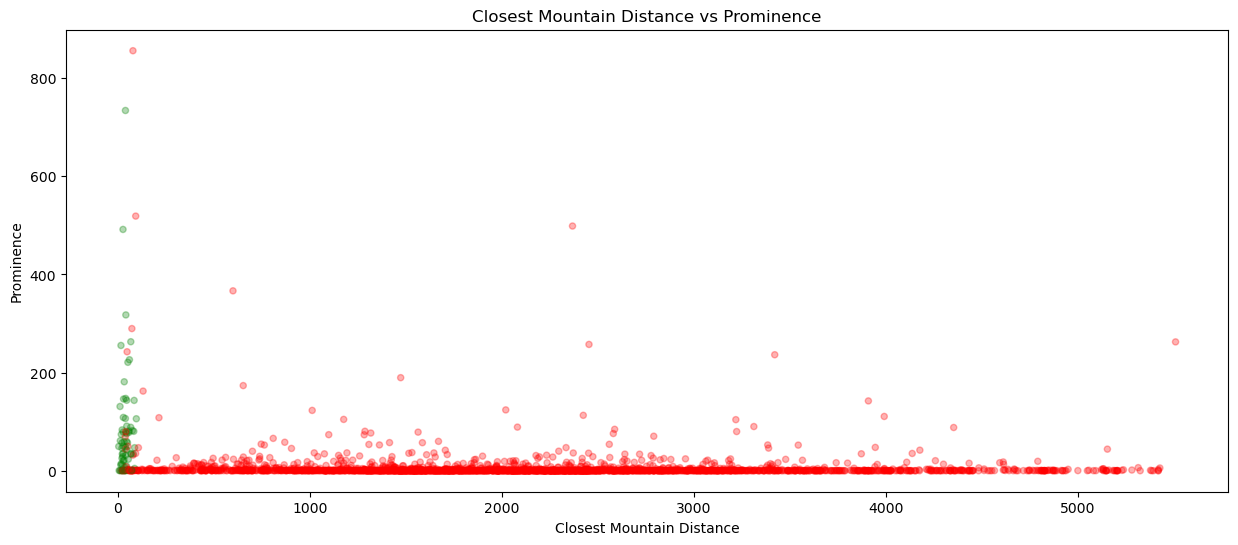

In [39]:
color_map = {"No": "red", "GNIS": "green"}
fig, ax = plt.subplots(figsize=(15, 6))
pgdf.plot(kind="scatter", x="Close_M_Di", y="prominence", c=pgdf['gnis'].map(color_map), alpha=0.3, ax=ax)
ax.set_title("Closest Mountain Distance vs Prominence")
ax.set_xlabel("Closest Mountain Distance")  
ax.set_ylabel("Prominence")

Text(0.5, 0, 'Closest Mountain Distance')

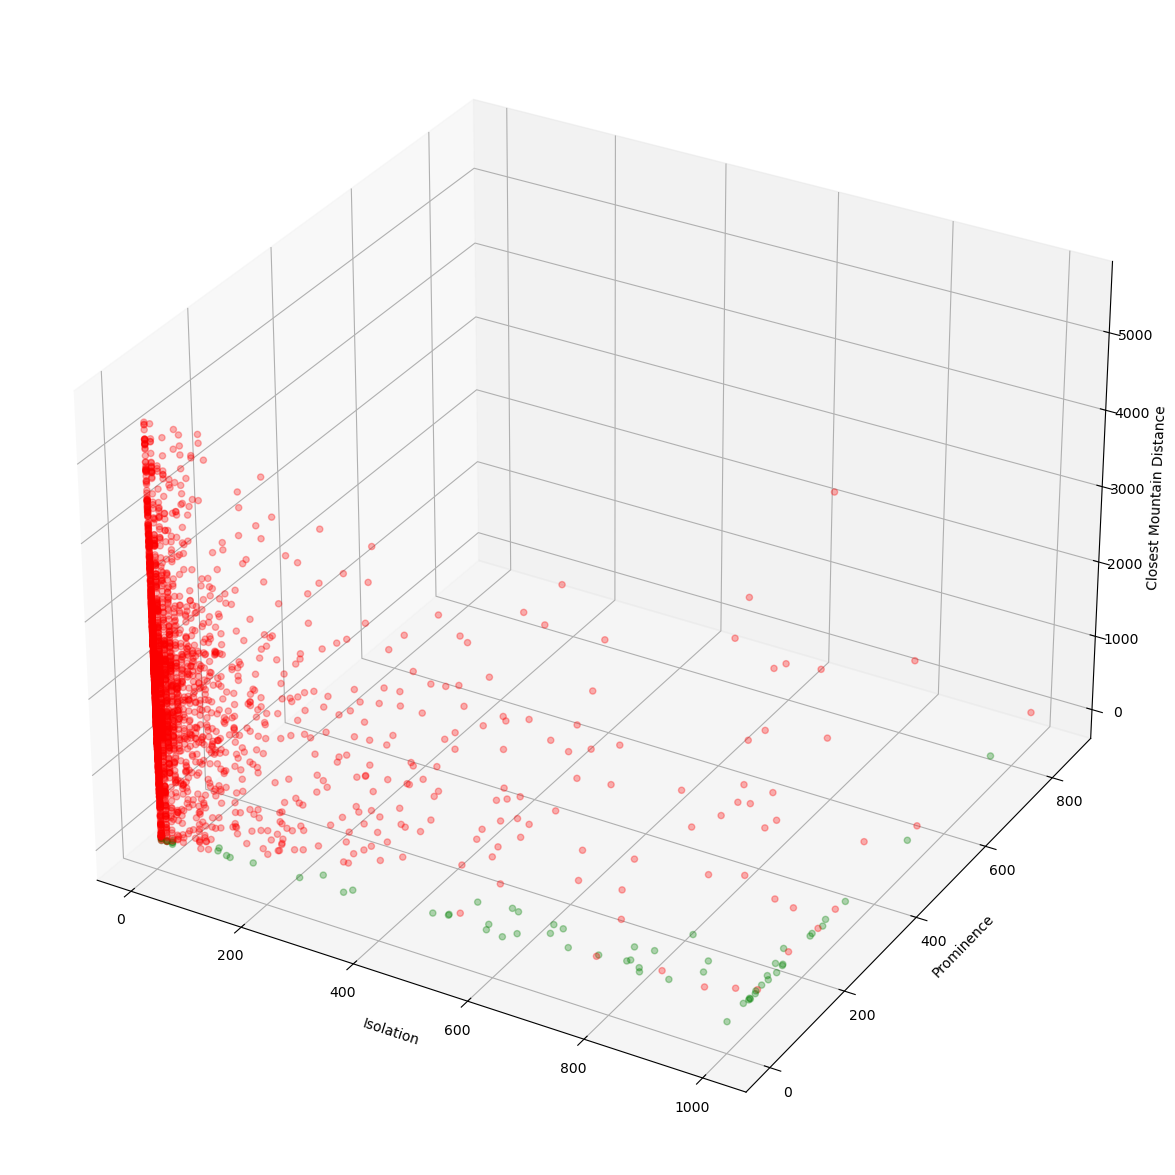

In [71]:
color_map = {"No": "red", "GNIS": "green"}
fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(111, projection='3d')
x = pgdf['iso_m']
y = pgdf['prominence'] 
z = pgdf['Close_M_Di']
ax.scatter(x, y, z, c=pgdf['gnis'].map(color_map), alpha=0.3)
ax.set_xlabel('Isolation')
ax.set_ylabel('Prominence')
ax.set_zlabel('Closest Mountain Distance')

Text(0.5, 0.5, 'Elevation')

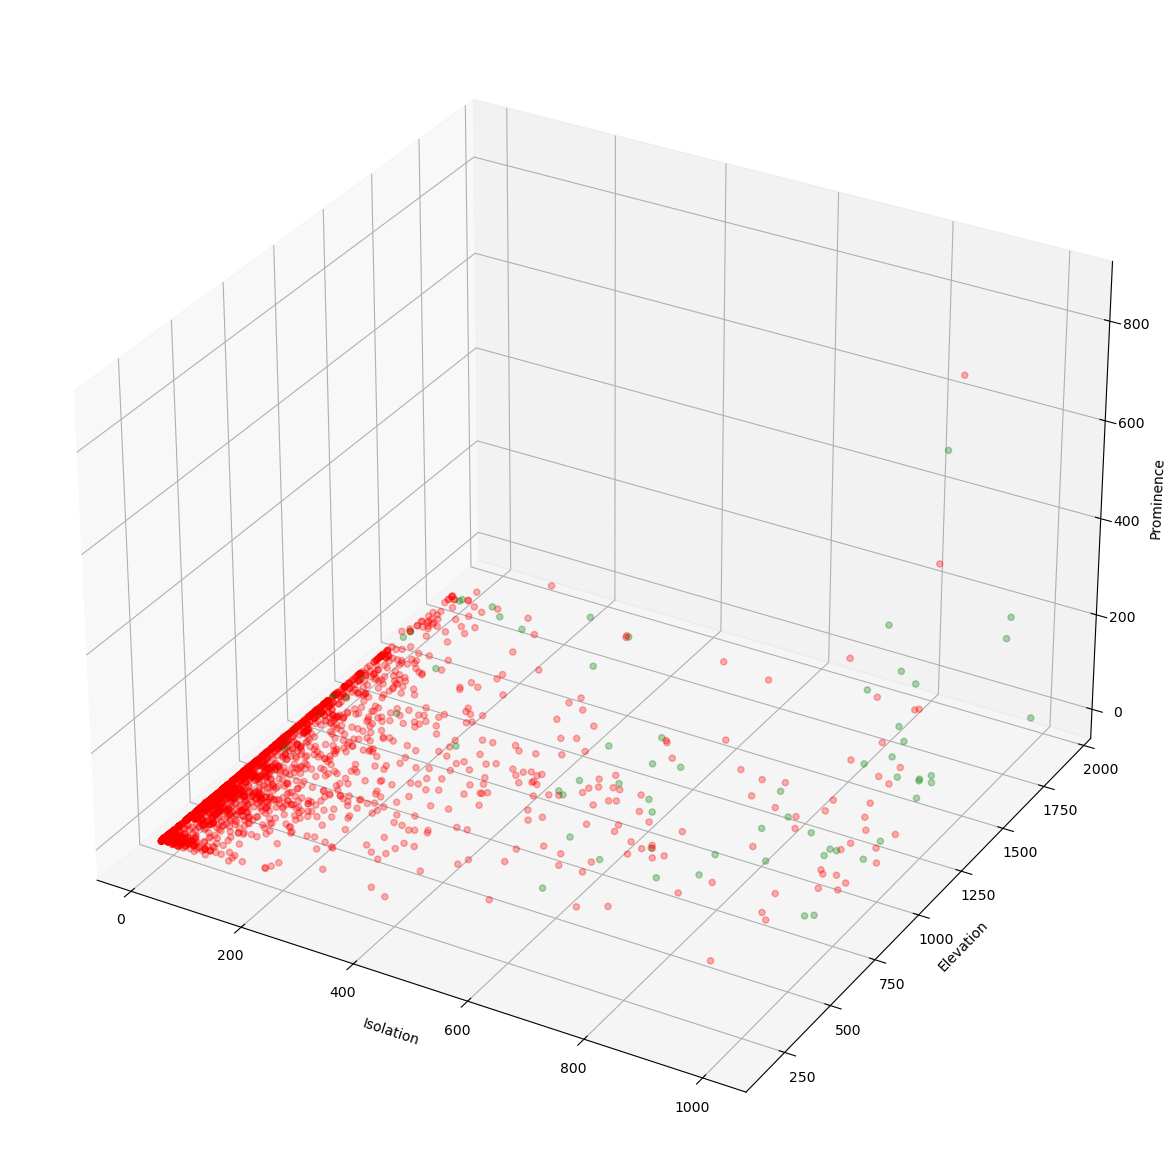

In [73]:
color_map = {"No": "red", "GNIS": "green"}
fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(111, projection='3d')
x = pgdf['iso_m']
z = pgdf['prominence'] 
y = pgdf['elevation']
ax.scatter(x, y, z, c=pgdf['gnis'].map(color_map), alpha=0.3)
ax.set_xlabel('Isolation')
ax.set_zlabel('Prominence')
ax.set_ylabel('Elevation')

In [97]:
raster.shape

(3600, 2259)

In [98]:
polygons = gpd.read_file('manual_poly_SR.shp')

In [99]:
polygons.crs

<Compound CRS: EPSG:5498>
Name: NAD83 + NAVD88 height
Axis Info [ellipsoidal|vertical]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
- H[up]: Gravity-related height (metre)
Area of Use:
- name: United States (USA) - CONUS and Alaska - onshore - Alabama; Alaska mainland; Arizona; Arkansas; California; Colorado; Connecticut; Delaware; Florida; Georgia; Idaho; Illinois; Indiana; Iowa; Kansas; Kentucky; Louisiana; Maine; Maryland; Massachusetts; Michigan; Minnesota; Mississippi; Missouri; Montana; Nebraska; Nevada; New Hampshire; New Jersey; New Mexico; New York; North Carolina; North Dakota; Ohio; Oklahoma; Oregon; Pennsylvania; Rhode Island; South Carolina; South Dakota; Tennessee; Texas; Utah; Vermont; Virginia; Washington; West Virginia; Wisconsin; Wyoming.
- bounds: (-168.26, 24.41, -66.91, 71.4)
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich
Sub CRS:
- NAD83
- NAVD88 height

In [100]:
polygons = polygons.to_crs(crs.to_epsg())

In [101]:
polygons.crs

<Projected CRS: EPSG:26919>
Name: NAD83 / UTM zone 19N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: North America - between 72°W and 66°W - onshore and offshore. Canada - Labrador; New Brunswick; Nova Scotia; Nunavut; Quebec. Puerto Rico. United States (USA) - Connecticut; Maine; Massachusetts; New Hampshire; New York (Long Island); Rhode Island; Vermont.
- bounds: (-72.0, 14.92, -66.0, 84.0)
Coordinate Operation:
- name: UTM zone 19N
- method: Transverse Mercator
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [102]:
polygons['line'] = polygons.boundary

In [162]:
px, py = np.gradient(raster, 10)
slope = np.sqrt(px ** 2 + py ** 2)

In [165]:
slope_deg = np.degrees(np.arctan(slope))

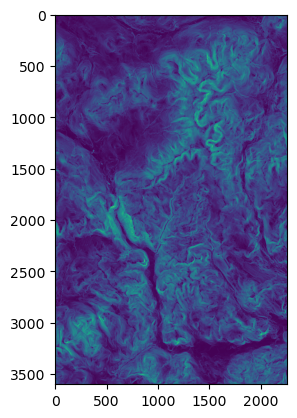

In [167]:
show_raster(slope_deg)

In [183]:
with rasterio.open('slope.tif', 'w',
                   driver='GTiff',
                   height=slope_deg.shape[0],
                   width=slope_deg.shape[1],
                   count=1,
                   dtype=str(slope_deg.dtype),
                   transform=transform,crs=crs) as dst:
            dst.write(slope_deg, 1)

In [232]:
with rasterio.open('slope.tif') as src:
    slope_rast = src.read(1)
    for index, row in polygons.iterrows():
        line = row.line
        out_slope, out_trans = mask(src, [line], crop=True, filled=True, nodata=-999)
        out_slope_array = out_slope.flatten()
        only_masked_pixels = np.delete(out_slope_array, np.where(out_slope_array == -999))
        min_slope = np.min(only_masked_pixels)
        max_slope = np.max(only_masked_pixels)
        avg_slope = np.average(only_masked_pixels)
        polygons.at[index, 'slope_min'] = min_slope
        polygons.at[index, 'slope_max'] = max_slope
        polygons.at[index, 'slope_avg'] = avg_slope

In [103]:
with rasterio.open('presrange10m.tif') as src:
    dem = src.read(1)
    for index, row in polygons.iterrows():
        line = row.line
        out_dem, out_trans = mask(src, [line], crop=True, filled=True, nodata=-999)
        out_dem_array = out_dem.flatten()
        only_masked_pixels = np.delete(out_dem_array, np.where(out_dem_array == -999))
        min_slope = np.min(only_masked_pixels)
        max_slope = np.max(only_masked_pixels)
        avg_slope = np.average(only_masked_pixels)
        polygons.at[index, 'elv_min'] = min_slope
        polygons.at[index, 'elv_max'] = max_slope
        polygons.at[index, 'elv_avg'] = avg_slope

In [105]:
# polygons

In [221]:
a = np.delete(out_slope_array, np.where(out_slope_array == -999))

In [226]:
np.average(a)

10.751807

In [219]:
len(out_slope_array)

1242

In [213]:
out_slope.shape

(1, 27, 46)

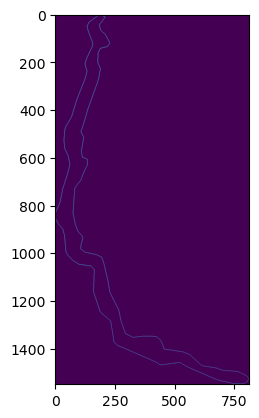

In [106]:
show_raster(out_dem)

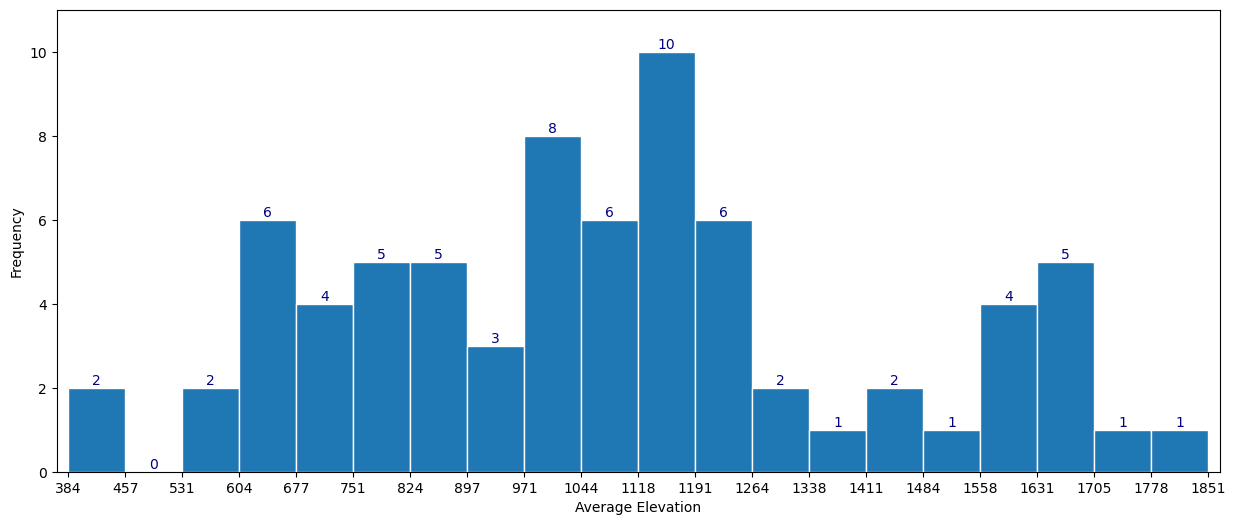

In [116]:
fig, ax = plt.subplots(1,1,figsize=(15, 6))
values, bins, bars = ax.hist(polygons['elv_avg'], bins=20, edgecolor='white')
ax.set_xlabel("Average Elevation")
ax.set_ylabel("Frequency")
ax.bar_label(bars, fontsize=10, color='navy')
ax.set_xticks(bins)
ax.margins(x=0.01, y=0.1)

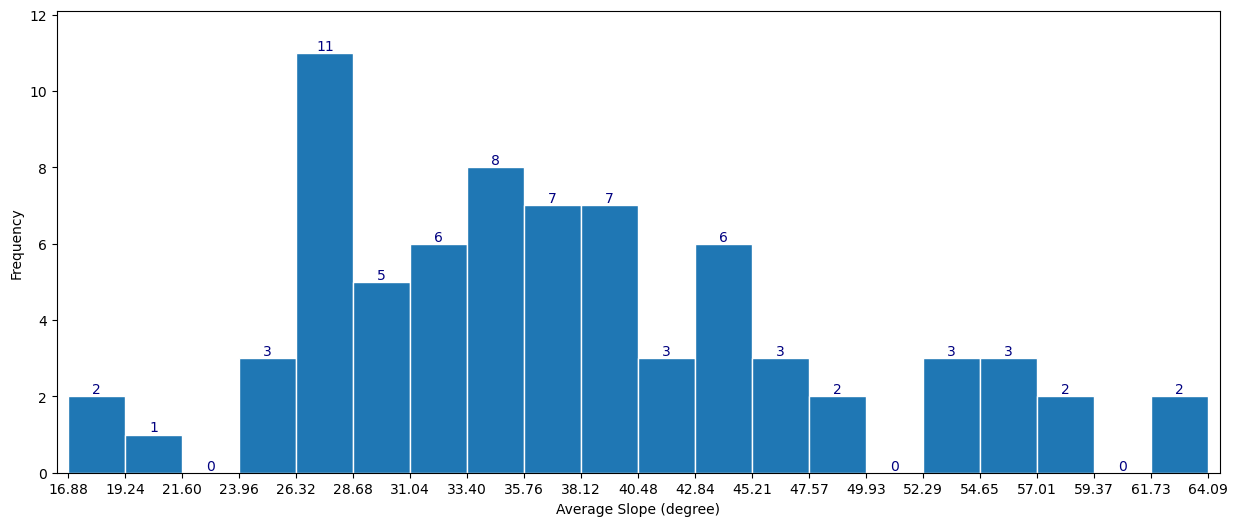

In [306]:
fig, ax = plt.subplots(1,1,figsize=(15, 6))
values, bins, bars = ax.hist(polygons['slope_max'], bins=20, edgecolor='white')
ax.set_xlabel("Average Slope (degree)")
ax.set_ylabel("Frequency")
ax.bar_label(bars, fontsize=10, color='navy')
ax.set_xticks(bins)
ax.margins(x=0.01, y=0.1)

In [110]:
# color_map = {15048: "blue", 15044: "green"}
# fig, ax = plt.subplots(figsize=(15, 6))
# polygons.plot(kind="scatter", x="slope_min", y="slope_max", c=polygons['fcode'].map(color_map), alpha=0.8, ax=ax)
# ax.set_title("Min vs Max Slope")
# ax.set_xlabel("Min Slope")  
# ax.set_ylabel("Max Slope")

In [109]:
# color_map = {15048: "blue", 15044: "green"}
# fig, ax = plt.subplots(figsize=(15, 6))
# polygons.plot(kind="scatter", x="slope_min", y="slope_avg", c=polygons['fcode'].map(color_map), alpha=0.8, ax=ax)
# ax.set_title("Min vs Max Slope")
# ax.set_xlabel("Min Slope")  
# ax.set_ylabel("Avg Slope")

In [108]:
# color_map = {15048: "blue", 15044: "green"}
# fig = plt.figure(figsize=(15, 15))
# ax = fig.add_subplot(111, projection='3d')
# x = polygons['slope_min']
# y = polygons['slope_max']
# z = polygons['slope_avg']
# ax.scatter(x, y, z, c=polygons['fcode'].map(color_map), alpha=0.8)
# ax.set_xlabel('Min Slope')
# ax.set_ylabel('Max Slope')
# ax.set_zlabel('Avg Slope')

In [14]:
o_polygons = gpd.read_file('d10_p3_regions_prominent_5m.shp')

In [15]:
o_polygons['line'] = o_polygons.boundary

In [16]:
with rasterio.open('presrange10m.tif') as src:
    dem = src.read(1)
    for index, row in o_polygons.iterrows():
        line = row.line
        out_dem, out_trans = mask(src, [line], crop=False, filled=True, nodata=-999)
        out_dem_array = out_dem.flatten()
        only_masked_pixels = np.delete(out_dem_array, np.where(out_dem_array == -999))
        min_slope = np.min(only_masked_pixels)
        max_slope = np.max(only_masked_pixels)
        avg_slope = np.average(only_masked_pixels)
        o_polygons.at[index, 'elv_min'] = min_slope
        o_polygons.at[index, 'elv_max'] = max_slope
        o_polygons.at[index, 'elv_avg'] = avg_slope

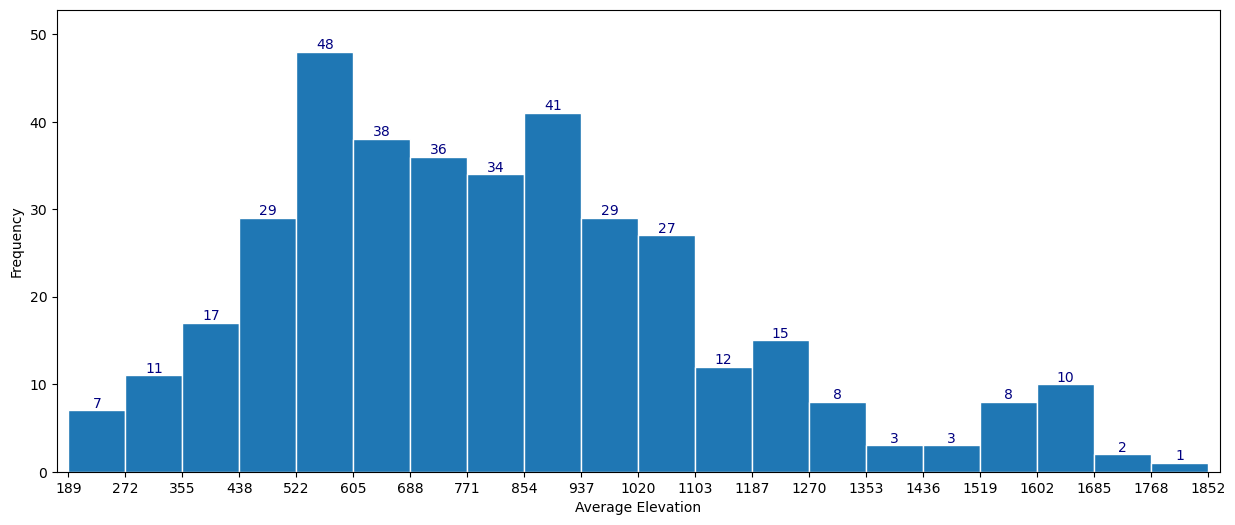

In [17]:
fig, ax = plt.subplots(1,1,figsize=(15, 6))
values, bins, bars = ax.hist(o_polygons['elv_avg'], bins=20, edgecolor='white')
ax.set_xlabel("Average Elevation")
ax.set_ylabel("Frequency")
ax.bar_label(bars, fontsize=10, color='navy')
ax.set_xticks(bins)
ax.margins(x=0.01, y=0.1)

In [19]:
with rasterio.open('slope.tif') as src:
    slope = src.read(1)
    for index, row in o_polygons.iterrows():
        line = row.line
        out_dem, out_trans = mask(src, [line], crop=False, filled=True, nodata=-999)
        out_dem_array = out_dem.flatten()
        only_masked_pixels = np.delete(out_dem_array, np.where(out_dem_array == -999))
        min_slope = np.min(only_masked_pixels)
        max_slope = np.max(only_masked_pixels)
        avg_slope = np.average(only_masked_pixels)
        o_polygons.at[index, 'slope_min'] = min_slope
        o_polygons.at[index, 'slope_max'] = max_slope
        o_polygons.at[index, 'slope_avg'] = avg_slope

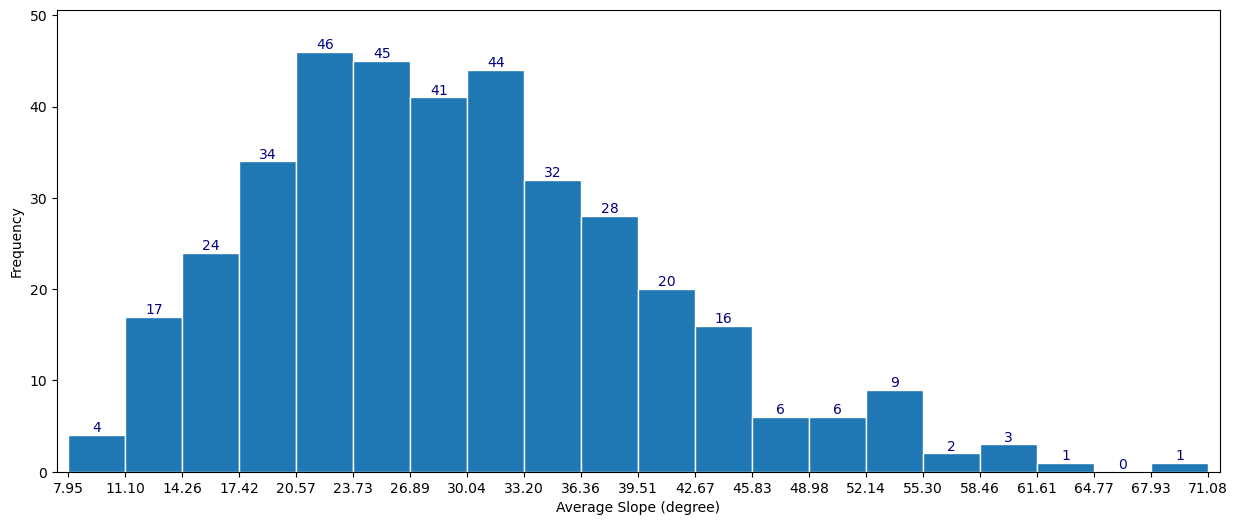

In [23]:
fig, ax = plt.subplots(1,1,figsize=(15, 6))
values, bins, bars = ax.hist(o_polygons['slope_max'], bins=20, edgecolor='white')
ax.set_xlabel("Average Slope (degree)")
ax.set_ylabel("Frequency")
ax.bar_label(bars, fontsize=10, color='navy')
ax.set_xticks(bins)
ax.margins(x=0.01, y=0.1)